# Annex 80 Weather Data Task Force Workshop - Day 3

## **Assembling future typical years (EN 15251-4)**

**Release history**

v0 : 2020-09-15

**License**

Licensed by La Rochelle University/LaSIE under a BSD 3 license (https://opensource.org/licenses/BSD-3-Clause).

**To use this code please cite the following publication:**

*Machard, A. , Inard, C., Alessandrini, J.M., Pelé, C., Ribéron, J.
A Methodology for Assembling Future Weather Files Including Heatwaves for Building Thermal Simulations from the European Coordinated Regional Downscaling Experiment (EURO-CORDEX) Climate Data*

https://doi.org/10.3390/en13133424

**Data**

Data for this workshop were downloaded from the CORDEX Platform https://cordex.org/

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [2]:
# These should be bias-adjusted data !
path = r"E:\MPI-REMO\2041-2060\2020-09-15_WDTF_Paris_hourly-weather-data-CORDEX_2041-2060-rcp85.csv"
df = pd.read_csv(path, index_col=0)
df.index = pd.to_datetime(df.index)
#  !!!! Modify here according to years !!!!
list_of_years = list(range(2041, 2061))

In [3]:
df

,tas,huss,sfcWind,ps,clt,rsds,hurs
2041-01-01 00:00:00,9.017419,6.906518,3.912424,100316.480000,9.802935,0.0,95.898671
2041-01-01 01:00:00,9.017419,6.906518,3.912424,100316.480000,9.802935,0.0,95.898671
2041-01-01 02:00:00,9.823847,6.880983,3.903217,100291.590000,9.758981,0.0,90.476536
2041-01-01 03:00:00,9.957915,6.829915,3.884803,100241.810000,9.671072,0.0,88.964239
2041-01-01 04:00:00,9.402612,6.778846,3.866389,100192.030000,9.583163,0.0,91.617199
...,...,...,...,...,...,...,...
2060-12-31 19:00:00,2.695703,4.370220,1.195758,99564.290000,1.216146,0.0,93.726766
2060-12-31 20:00:00,2.307767,4.250021,1.140537,99573.406667,1.471096,0.0,93.730461
2060-12-31 21:00:00,1.892694,4.129822,1.085316,99582.523333,3.255291,0.0,93.849793
2060-12-31 22:00:00,1.384454,4.009624,1.030096,99591.640000,5.039487,0.0,94.530509


## **Defining functions to calculate the FS statistic (for each variable and month), and the sum of the ranks**

In [4]:
# We calculate the FS for each variable var (tas, hurs, rsds), for each month m 
# nb is the number of days in the month

def get_FS(var, m, nb):
    
    var_df = pd.DataFrame({'Var':var})
    # Calculating daily averages
    var_df = var_df.resample('24H').mean()
    var_df['month'] = var_df.index.month
    var_df['day'] = var_df.index.day
    var_df['year'] = var_df.index.year
    
    ### Deleting all the 29/2 for simplicity
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2044))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2048))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2052))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2056))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2060))]
    
    # Creating a serie of daily variable for that month (m) with data from the all the years (20 in our case)
    var_all_years = var_df.loc[(var_df['month'] == m)]

    del var_all_years['day']
    del var_all_years['year']
    del var_all_years['month']
    
    # Creating the distribution functions. 
    
    # F is the distribution function for one year (31 in January + 1)
    serie_F = (pd.Series(range(1, (nb+1))))/(nb+1)  ## Equation 2 RANK K(p) DIVIDED BY N+1
    
    # PHI is the distribution function for the 20 years.
    serie_PHI = (pd.Series(range(1, (nb*20+1))))/(nb*20+1)  ## Equation 3 RANK J(p) DIVIDED BY n+1


    def get_yearly_sum_FS(var_one_year, var_all_years):
        
        # Sorting the variable by ascending order
        var_one_year = var_one_year.sort_values(ascending=True, by=['Var']).squeeze()
        var_all_years = var_all_years.sort_values(ascending=True, by=['Var']).squeeze()
        
        # Creating a dataframe with the distribution function for 1 year in column F & the temperatures of 1 year in column Variables
        df_one_year = pd.DataFrame({'F': serie_F.values, 'Variables': var_one_year.values, 'Equivalent-PHI': "", 'FS': ""})
        
        # Creating a dataframe with the distribution function for 20 years in column PHI & the variables of 20 years in column Variables
        df_all_years = pd.DataFrame({'PHI': serie_PHI.values, 'Variables': var_all_years.values})
        
        # Finding in df_all_years the equivalent var than in df_one_year
        for i in range(len(df_one_year)):
            # Getting the var in df one_year
            var = df_one_year.iloc[i]['Variables']
            # Finding the equivalent var in df all years & storing that row (equivalent temp & Phi of df all years)
            row = df_all_years.loc[df_all_years['Variables'] == var]
            # Getting phi from that row
            phi = row.iloc[0]['PHI']
            # Adding phi to the column 'Equivalent-PHI' in df_one_year
            df_one_year.loc[i, 'Equivalent-PHI'] = phi
            # Calculating FS
            df_one_year.loc[i, 'FS'] = abs(df_one_year.loc[i, 'F']-df_one_year.loc[i, 'Equivalent-PHI'])
            
        # Calculating FS, the sum of the differences (F - PHI) for that month & that year
        sum_FS = df_one_year['FS'].sum()
        
        return sum_FS

    # Creating an empty list in each we will store the FS sums
    list_of_sum_FS = []
    
    ## Iterating year by year (through the 20 years)
    for i, g in var_all_years.groupby(np.arange(len(var_all_years)) // nb):
    # Getting the sum_FS for each year
        summ_FS = get_yearly_sum_FS(g, var_all_years)
    # Adding the sum_FS to list_of_sum_FS
        list_of_sum_FS.append(summ_FS)

    return list_of_sum_FS

In [5]:
# This function calcules the rank for each variable (tas, hurs, and rsds), and the sum of the ranks of the 3 variables 
# It takes as arguments the FS of each variable

def get_sum(FS_temp, FS_hs, FS_rs):

    def get_rang(FS):
        
        # Creating a dataframe indexed with the years for list_of_sum_FS
        df_fs = pd.DataFrame({'Years': list_of_years, 'FS': FS, 'rang': ""})

        # Sorting the dataframe in ascending order of FSs with the corresponding year
        df_fs = df_fs.sort_values(['FS'], ascending=True)
        
        # Adding the rank column
        df_fs['rang'] = list(range(1, 21)) # nb of years
        
        # Sorting dataframe per ascending year
        df_fs = df_fs.sort_values(['Years'], ascending=True)
        
        # Returning the rank of each year
        rang = df_fs['rang']
        return rang
    
    # Calling the function and getting the rank
    rang_temp = get_rang(FS_temp)
    rang_hs = get_rang(FS_hs)
    rang_rs = get_rang(FS_rs)

    # Getting the rank of each parameter for each year
    df = pd.DataFrame({'Years': list_of_years, 'Rang-temp': rang_temp, 'Rang-hs': rang_hs, 'Rang-rs': rang_rs})
    
    # Summing the rank for each year
    df['Rang-somme'] = df['Rang-temp'] + df['Rang-hs'] + df['Rang-rs']
    
    # Sorting in order of rank
    df = df.sort_values(['Rang-somme'], ascending=True)
    df = df.reset_index(drop=True)
    
    return df

## **Calling the functions defined above**

In [6]:
# Number of days in the 12 months
ndays = [31,28,31,30,31,30,31,31,30,31,30,31]

# Creating an empty dictionnary to store the FS for each variable (temp: tas, hs: hurs, rs:rsds)
FS = {'temp':[], 'hs':[], 'rs':[]}

# Creating an empty list to store the ranks of the years for each month
list_dfs_months = []

# For each month and each variable, calling the function get_FS which returns the FS for that variable
# For each month appending to list_dfs_months the ranks (function get_sum)

for month in range(12):
    
    FS['temp'].append(get_FS(df['tas'],month+1,ndays[month]))
    FS['hs'].append(get_FS(df['huss'],month+1,ndays[month]))
    FS['rs'].append(get_FS(df['rsds'],month+1,ndays[month]))
    
    list_dfs_months.append(get_sum(FS['temp'][month], FS['hs'][month],FS['rs'][month]))

In [7]:
# In list_df_months, for each month, the years are classified by the sum of the ranks
list_dfs_months

[    Years  Rang-temp  Rang-hs  Rang-rs  Rang-somme
 0    2052          1        1        2           4
 1    2057          3        4        7          14
 2    2041          6        9        5          20
 3    2045         13        6        4          23
 4    2059          4        3       17          24
 5    2043          2        8       15          25
 6    2044          7       16        3          26
 7    2054          8        7       11          26
 8    2050         11       10        6          27
 9    2042         15        5       13          33
 10   2058          5       11       18          34
 11   2053         17       17        1          35
 12   2048         14       14        8          36
 13   2047          9       15       12          36
 14   2046         16        2       19          37
 15   2051         19       12        9          40
 16   2060         10       13       20          43
 17   2055         12       19       14          45
 18   2049  

In [8]:
# 2nd order variable Wind
df_wind = pd.DataFrame({'Wind':df['sfcWind']})
df_wind.index = pd.to_datetime(df_wind.index)

# Calculating the monthly mean of the wind
df_wind = df_wind.resample('1M').mean()
df_wind['month']  = df_wind.index.month
df_wind['year']  = df_wind.index.year

In [9]:
df_wind

,Wind,month,year
2041-01-31,4.368984,1,2041
2041-02-28,3.661926,2,2041
2041-03-31,4.221243,3,2041
2041-04-30,3.424755,4,2041
2041-05-31,3.571664,5,2041
...,...,...,...
2060-08-31,3.167244,8,2060
2060-09-30,3.382771,9,2060
2060-10-31,3.015227,10,2060
2060-11-30,4.349160,11,2060


In [10]:
# Calculating, for each month, the mean wind speed of the 20 years
df_wind_monthly_mean = pd.pivot_table(df_wind, values='Wind',index=["month"], aggfunc='mean')

# Wind mean month by month and year per year
df_wind_sorted_by_month = pd.pivot_table(df_wind, values='Wind',index=['month','year'])

In [11]:
df_wind_monthly_mean

,Wind
month,
1,4.190164
2,4.076788
3,3.960935
4,3.623805
5,3.514355
6,3.044711
7,3.014519
8,3.167583
9,3.365398


In [12]:
df_wind_sorted_by_month

Wind
month year          
1     2041  4.368984
      2042  3.913072
      2043  4.146325
      2044  3.861516
      2045  4.883327
...              ...
12    2056  3.826426
      2057  5.626236
      2058  4.636906
      2059  3.887889
      2060  4.805751

[240 rows x 1 columns]

In [13]:
# This function sorts the wind years by order of least deviation ('Difference') compared to the 20 years monthly mean

def get_df_wind(wind_all_month, wind_month_mean):
    
    # Creating a DataFrame for the wind data of that month
    df_wind_month = pd.DataFrame({'Vitesse': wind_all_month, 'Difference': ""})
    
    # Calculating the difference between the mean of this year & the mean of all years
    df_wind_month['Difference'] = abs(wind_month_mean - df_wind_month['Vitesse'])
    
    # Classifying the wind mean values in ascending order
    df_wind_month = df_wind_month.sort_values(['Difference'], ascending=True)
    
    # Storing the years by order in the 'Years-sorted' column
    df_wind_month['Years-sorted'] = df_wind_month.index.values
    
    # Returning the DataFrame with years sorted in order 
    del df_wind_month['Vitesse']
    df_wind_month = df_wind_month.reset_index(drop=True)
    
    return df_wind_month

In [14]:
# Calling the function, iterating through each month and adding the years sorted by winds to list_dfs_months
liste_years_wind_sorted = []

for month in range(12):
    liste_years_wind_sorted.append(get_df_wind(df_wind_sorted_by_month.Wind[month+1][0:30],df_wind_monthly_mean.Wind[month+1]))
    list_dfs_months[month]['Years-sorted-by-wind'] = liste_years_wind_sorted[month]['Years-sorted']

In [15]:
list_dfs_months

[    Years  Rang-temp  Rang-hs  Rang-rs  Rang-somme  Years-sorted-by-wind
 0    2052          1        1        2           4                  2043
 1    2057          3        4        7          14                  2047
 2    2041          6        9        5          20                  2041
 3    2045         13        6        4          23                  2048
 4    2059          4        3       17          24                  2042
 5    2043          2        8       15          25                  2055
 6    2044          7       16        3          26                  2044
 7    2054          8        7       11          26                  2059
 8    2050         11       10        6          27                  2057
 9    2042         15        5       13          33                  2050
 10   2058          5       11       18          34                  2049
 11   2053         17       17        1          35                  2058
 12   2048         14       14        

In [16]:
# Creating an empty list that will contain the typical years in order per month
list_years=[]

# k is the number of years we consider. If the year classified 3 and 4 have the same rank, we consider both of them.
k=0
for month in range(12):
    rang,year_min = 3000,0
    
    # Finding out if k = 3 (default), 4 or 5
    if list_dfs_months[month]['Rang-somme'][3] == list_dfs_months[month]['Rang-somme'][2]:
        k = 4
    if list_dfs_months[month]['Rang-somme'][4] == list_dfs_months[month]['Rang-somme'][2]:
        k = 5
    if ((k!=4) and (k!=5)):
        k = 3
        
    # Iterating, for each month, through the 3 years with the smallest rank 
    for year in list_dfs_months[month][0:k].Years:
        
        # Calculating the rank of that year in the years-sorted-by-wind
        wind_year = list_dfs_months[month]['Years-sorted-by-wind']
        
        # Storing that rank in rg_year
        rg_year=wind_year[wind_year==year].index.values[0]
        
        # If the rank of the year is < to rang (initially set as a high number 3000), the minimum year is replaced
        if rg_year < rang:
            year_min = list_dfs_months[month]['Years-sorted-by-wind'][rg_year]
            
    # Adding year_min to list_years
    list_years.append(year_min)

In [17]:
list_years

[2041, 2047, 2042, 2041, 2042, 2056, 2057, 2054, 2045, 2046, 2042, 2050]

In [18]:
# Creating the dataframe of the typical year

list_months_str = ['01','02','03','04','05','06','07','08','09','10','11','12']
list_years_str = [str(x) for x in list_years]
dates = [i + '-' + j for i, j in zip(list_years_str, list_months_str)] 

df_type = pd.DataFrame({})
for d in dates:
    df_type = df_type.append(df[d])

In [19]:
df_type

,tas,huss,sfcWind,ps,clt,rsds,hurs
2041-01-01 00:00:00,9.017419,6.906518,3.912424,100316.480000,9.802935,0.0,95.898671
2041-01-01 01:00:00,9.017419,6.906518,3.912424,100316.480000,9.802935,0.0,95.898671
2041-01-01 02:00:00,9.823847,6.880983,3.903217,100291.590000,9.758981,0.0,90.476536
2041-01-01 03:00:00,9.957915,6.829915,3.884803,100241.810000,9.671072,0.0,88.964239
2041-01-01 04:00:00,9.402612,6.778846,3.866389,100192.030000,9.583163,0.0,91.617199
...,...,...,...,...,...,...,...
2050-12-31 19:00:00,6.132684,5.780992,3.964330,101149.880000,9.998352,0.0,98.752481
2050-12-31 20:00:00,6.417421,5.829312,4.053487,101147.726667,9.920793,0.0,97.629013
2050-12-31 21:00:00,6.552191,5.877632,4.142643,101145.573333,9.762379,0.0,97.518170
2050-12-31 22:00:00,6.515710,5.925952,4.231800,101143.420000,9.603965,0.0,98.557709


## **Visualizing the typical year**

In [20]:
# 20 years temperature in temp20y

temp20y = pd.DataFrame(df['tas'])
temp20y.index = pd.to_datetime(temp20y.index)
temp20y['year'] = temp20y.index.year
temp20y['month'] = temp20y.index.month
temp20y['day'] = temp20y.index.day
leap_year = [2044,2048,2052,2056,2060,2064,2068]

for l in leap_year:
    temp20y = temp20y[~((temp20y['month'] == 2) & (temp20y['day'] == 29) & (temp20y['year'] == l))]

del temp20y['year']
del temp20y['month']
del temp20y['day']
temp20y = temp20y.squeeze()

n = 8760  #chunk row size

# Splitting each year of temperature in list_temp_each_year
list_temp_each_year = [temp20y [i:i+n] for i in range(0,temp20y.shape[0],n)]
list_years_l = [x.to_list() for x in list_temp_each_year]

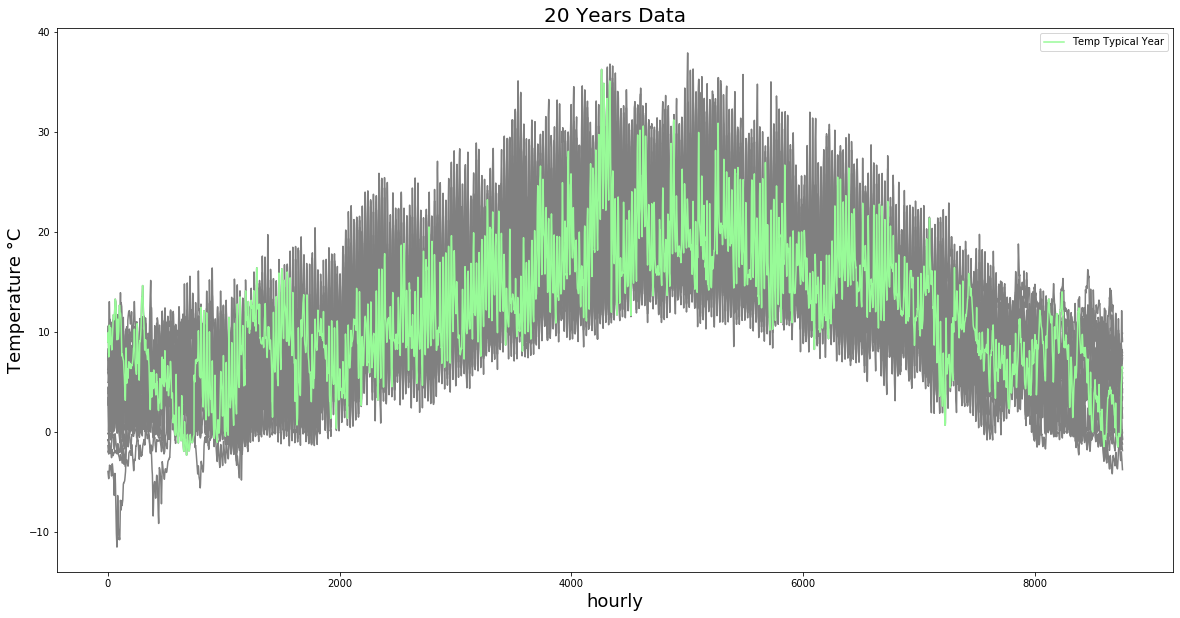

In [21]:
# Plotting the 20 years of temperature and the typical year

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
for i in range(len(list_years_l)):
    ax.plot(list_years_l[i], color='grey')
ax.plot(df_type['tas'].to_list(),color='palegreen',label='Temp Typical Year')
ax.set_xlabel('hourly',fontsize=18)
ax.set_ylabel('Temperature °C',fontsize=18)
ax.set_title('20 Years Data',fontsize=20)
ax.legend()

# **Finding Heatwaves**

**This method was created by:**
*Ouzeau, G., Soubeyroux, J-M., Schneider,M., Vautard R., Planton, S.
Heat waves analysis over France in present and future climate: Application of a new method on the EURO-CORDEX ensemble*

https://doi.org/10.1016/j.cliser.2016.09.002

**It was coded and used for building simulations by:**
*Machard, A. , Inard, C., Alessandrini, J.M., Pelé, C., Ribéron, J.
A Methodology for Assembling Future Weather Files Including Heatwaves for Building Thermal Simulations from the European Coordinated Regional Downscaling Experiment (EURO-CORDEX) Climate Data*

https://doi.org/10.3390/en13133424


In [22]:
# !!! These data (path_hist) MUST BE 20 YEARS OF BIAS-ADJUSTED DATA !!!
path_hist = r'C:\Users\amachard\Documents\SIMULATIONS-CLIMAT\CLIMATE_FILES\A_Janvier_2019_DATA_CSTB/1976-2005\serie_3hrs_temp_MPI_1976-2005_PARIS'
df_hist = pd.read_csv(path_hist, index_col=0,header=None)
df_hist.index = pd.to_datetime(df_hist.index)

In [23]:
temp_hist = df_hist['1986':'2005'].squeeze().resample('24H').mean() # Keeping only 20 years and calculating daily temperature means
# If data imported are already 20 years, please use this line instead of above line: temp_hist = df_hist.squeeze().resample('24H').mean()
temp_future = df['tas'].squeeze().resample('24H').mean()

In [24]:
# Temperature thresholds to characterize heatwaves
spic = temp_hist.quantile(0.995)
sdeb = temp_hist.quantile(0.975)
sint = temp_hist.quantile(0.95)

In [25]:
# This function detects heatwaves over a 20 years dataset. 
# It returns a list of heatwaves, the heatwaves, a list of their severities a list of their duration, and a list of their Tmax

def get_dict_hws(daily_temp, spic, sdeb, sint):
    
    # Creating result, an empty dataframe with a series of 20 years daily temperatures
    result = pd.DataFrame({'Daily_Temp': daily_temp, 'sup_SPIC':"", '>SDEB':"", 'cons_SDEB':""})
    result['month']=result.index.month
    
    # Analysing only months from June to September included. !!! These must be replaced according to the summer period of the city of interest !!!
    filter_mask = (result['month'] > 5) & (result['month'] < 10)
    df = result[filter_mask]
    df.index = pd.to_datetime(df.index)
    del df['month']
    
    # Finding where the daily temperature exceeds the threshold SPIC
    df['sup_SPIC'] = np.where(df['Daily_Temp']>spic,df['Daily_Temp'],int(0))
    
    # Finding where the daily temperature exceeds the threshold SDEB
    df['>SDEB'] = np.where(df['Daily_Temp']>sdeb,df['Daily_Temp'],int(0))
    
    # Adding all the temperatures above the SDEB threshold to temp_sdeb
    temp_sdeb = df['>SDEB'].tolist()
    
    # Analyzing if temperatures are consecutive with a minimum of 3 days gap. If yes, filling the 'in between' days wit h1
    for i in range(0,len(temp_sdeb)-4):
    
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+4]!=0)):
            temp_sdeb[i+1]=1
            temp_sdeb[i+2]=1 
            temp_sdeb[i+3]=1
            
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+3]!=0)):
            temp_sdeb[i+1]=1
            temp_sdeb[i+2]=1 
            
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+2]!=0)):
            temp_sdeb[i+1]=1
            
    
    # Adding the list temp_sdeb to the dataframe column 'cons_SDEB'
    df['cons_SDEB'] = temp_sdeb
    
    # Replacing the 1 values with the temperature
    df['cons_SDEB'] = np.where(df['cons_SDEB']==1,df['Daily_Temp'],df['cons_SDEB'])
    
    # Filling with 0 if the heatwaves temperatures fall under the SINT threshold
    df['cons_SDEB'] = np.where(df['cons_SDEB']<sint,int(0),df['cons_SDEB'])
    
    # Keeping only the heatwaves temperatures where there is no 0
    df_reduit = df.loc[(df['cons_SDEB']!=0)]
    del df_reduit['Daily_Temp']
    del df_reduit['>SDEB']
    
    # Storing in hws a list of heatwaves (sorting through consecutive days)
    hws_idx = []
            
    for i in range(0, len(df_reduit)):
        if (df_reduit.index.dayofyear[i]-df_reduit.index.dayofyear[i-1])!=1:
            hws_idx.append(int(np.where(df_reduit.index==df_reduit.index[i])[0]))
    
    hws = []
    for i in range(0, len(hws_idx)-1):
        hws.append(df_reduit.iloc[hws_idx[i]:hws_idx[i+1]])
    
    for i in range(len(hws_idx)-1, len(hws_idx)):
        hws.append(df_reduit.iloc[hws_idx[i]:len(df_reduit)])
    
    ## Keeping in hws2 only the hws for which there is a temp > SPIC 
    hws2 = []
    for i in range(0, len(hws)):
        for a in range(0, len(hws[i])):
            if (hws[i]['sup_SPIC'][a]) > 1:
                hws2.append(hws[i])
                break
    
    ## Keeping in hws3 only the hws that are min 5 days long
    hws3 = []
    for i in range(0, len(hws2)):
        if len(hws2[i])>=5:
            hws3.append(hws2[i])
    
    # Calculating for each heatwave the severity and adding it to the list severities
    severities=[]
    for i in range(0, len(hws3)):
        b=0
        for j in range(0, len(hws3[i])):
            if (hws3[i]['cons_SDEB'][j])>sdeb:
                x = (hws3[i]['cons_SDEB'][j])-sdeb
                b=b+x
            
        severity=b/(spic-sdeb)
        severities.append(severity)
    
    # Calculating for each heatwave the length and adding it to the list lenghts
    lenghts=[]
    for i in range(0, len(hws3)):
        lenghts.append(len(hws3[i]))
    
    # Calculating for each heatwave the Tmax and adding it to the list maxs
    maxs=[]
    for i in range(0, len(hws3)):
        maxs.append(hws3[i]['sup_SPIC'].max())
    
    # Creating liste_hws, a list of lists containing all heatwaves characteristics
    liste_hws = [] 
    for (e, f, g, h) in zip(hws3, lenghts, maxs, severities): 
         liste_hws.append([e,f,g,h])

    return liste_hws, hws3, severities, lenghts, maxs

In [26]:
# Calling the function

list_hws_hist = get_dict_hws(temp_hist,spic,sdeb,sint)
list_hws_future = get_dict_hws(temp_future,spic,sdeb,sint)

C:\Users\amachard\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\amachard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\amachard\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [27]:
list_hws_hist

([[             sup_SPIC  cons_SDEB
   0                               
   1993-08-23   0.000000  21.407379
   1993-08-24   0.000000  24.941468
   1993-08-25  27.729950  27.729950
   1993-08-26  28.416534  28.416534
   1993-08-27   0.000000  25.538147,
   5,
   28.416534375,
   4.971529199822286],
  [             sup_SPIC  cons_SDEB
   0                               
   1997-06-14  25.907974  25.907974
   1997-06-15   0.000000  22.541237
   1997-06-16   0.000000  23.082710
   1997-06-17  25.969536  25.969536
   1997-06-18  27.301514  27.301514
   1997-06-19  29.184570  29.184570
   1997-06-20   0.000000  25.508583,
   7,
   29.18457025,
   6.529046102449145],
  [             sup_SPIC  cons_SDEB
   0                               
   1999-08-02   0.000000  25.334168
   1999-08-03  26.628449  26.628449
   1999-08-04   0.000000  24.943238
   1999-08-05   0.000000  23.028839
   1999-08-06   0.000000  25.339081
   1999-08-07   0.000000  24.487365
   1999-08-08   0.000000  25.516235
   1999

## **Visualizing heatwaves**

In [28]:
c='wheat'
ec='chocolate'

# Creating patches (circles)
patches = []

# For each heatwave:
# x is the lenght
# y is the tmax
# bubblesize is the severity

# Historical heatwaves
for i in range(0, len(list_hws_hist[2])):
        fig_x_hist = list_hws_hist[3][i]
        fig_y_hist = list_hws_hist[4][i]
        fig_bubblesize_hist = list_hws_hist[2][i]/10
        circle_hist = Circle((fig_x_hist, fig_y_hist), fig_bubblesize_hist, color=c)
        patches.append(circle_hist)
    
# Future heatwaves
for i in range(0, len(list_hws_future[2])):
        fig_x_future = list_hws_future[3][i]
        fig_y_future = list_hws_future[4][i]
        fig_bubblesize_future= list_hws_future[2][i]/10
        circle_future = Circle((fig_x_future, fig_y_future), fig_bubblesize_future, color=ec)
        patches.append(circle_future)

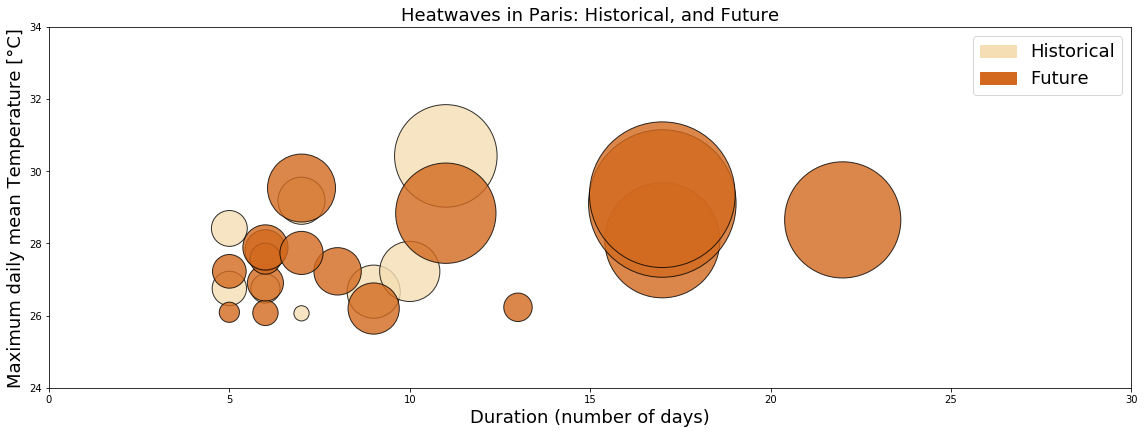

In [29]:
### `PLOT  ####
p = PatchCollection(patches, match_original=True, edgecolor='black') ## this means that the colors given to the patches will be used
p.set_alpha(0.8) ## SET TRANSPARENCY OF BUBBLES
fig, ax = plt.subplots(figsize=(16, 12))
ax.add_collection(p)
ax.set_aspect('equal') ## keep the circles round
plt.legend([circle_hist, circle_future], ['Historical','Future'],fontsize=18)
plt.ylim(top=34,bottom=24)
plt.xlim(right=30, left=0)
plt.xlabel("Duration (number of days)", fontsize=18)
plt.ylabel("Maximum daily mean Temperature [°C]", fontsize=18)
plt.title('Heatwaves in Paris: Historical, and Future', fontsize=18)
plt.tight_layout()
plt.show()